# Exploration of the MNIST - Dataset 

The popular MNIST Dataset contains images of handwritten digits. In this notebook, I will explore  the dataset by applying kmeans-clustering and by training a simple linear neural network for classification. 

In [8]:
%matplotlib inline
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix

import numpy as np

from livelossplot import PlotLosses

import pickle

In [2]:
#load MNIST Dataset and convert to numpy array for clustering 

train = datasets.MNIST('./data', train=True, download=True)
test = datasets.MNIST('./data', train=False, download=True)
data_train = train.data.numpy()
labels_train = train.targets.numpy()
data_test = test.data.numpy()
labels_test = test.targets.numpy()

# Clustering

As a first mean of exploration, I will apply k-means clustering on the data set. K-Means works by assigning each sample to its nearest cluster centroid, then recalculating the centroid based on the points assigned to it. As initialization, k-means++ is used, meaning that the initial centroids are points present in the data set. The first is chosen according to uniform probabilities, for the subsequent ones points which are further away from the existing centroids are more likely to be chosen. 

In [5]:
n_digits = 10
n_samples = data_train.shape[0]
n_features = data_train.shape[1]*data_train.shape[1]
kmeans = KMeans(n_clusters=n_digits, n_jobs=-1)
# the default initialization method is k-means++ 
kmeans.fit(data_train.reshape(n_samples, n_features))
 
centroids = kmeans.cluster_centers_ 



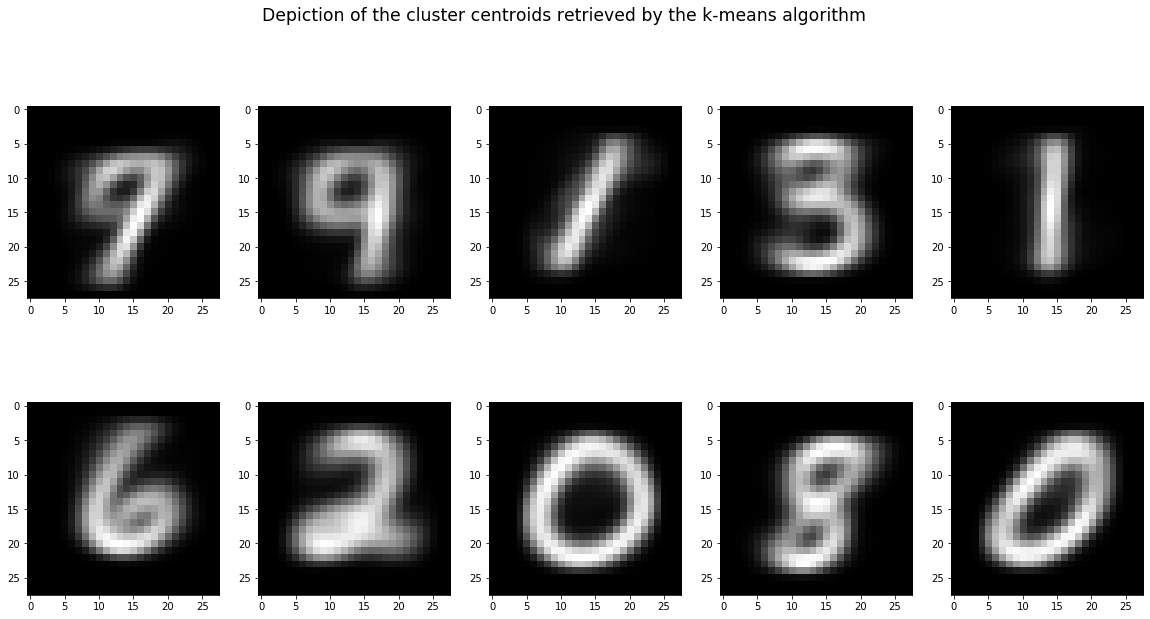

In [6]:
fig2, ax2 = plt.subplots(2,5,figsize=(20,10))

k = 0
for i in range(2):    
    for j in range(5):
        c = np.reshape(centroids[k], (28,28))
        ax2[i,j].imshow(c, interpolation='nearest', cmap='gray')
        k = k+1
plt.suptitle('Depiction of the cluster centroids retrieved by the k-means algorithm ', fontsize="xx-large")
plt.show()

## Centroids

The ten centroids do not correspond to the ten digits present in the data set. Over several runs, I have observed that the digits 0, 1 and 9 are usually represented by several centroids while the digits 4, 5 and 7 only seldomly can be found among the centroids. This pattern hints at the fact that the latter digits might be drawn quite differently by different people (e.g. a 7 either with or without a line across), so that the different examples are not identified as belonging to the same cluster. 


In [9]:
n_clusters = range(10, 30)
'''inertias = []
for n in n_clusters:
    k = KMeans(n_clusters = n, n_jobs = -1)
    k.fit(data_train.reshape(n_samples, n_features))
    inertias.append(k.inertia_)
pickle.dump( inertias, open( "inertias.p", "wb" ) )
'''
# the inertia values are computed once and stored for computational feasibility 
inertias = pickle.load( open( "inertias.p", "rb" ) )

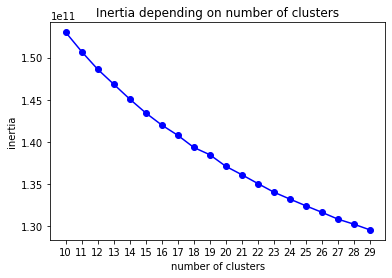

In [10]:
plt.plot(n_clusters, inertias, '-o', color='blue')
plt.xlabel('number of clusters')
plt.ylabel('inertia')
plt.xticks(n_clusters)
plt.title('Inertia depending on number of clusters')
plt.show()

##  How many clusters make sense?

As seen above, choosing 10 clusters does not result in satisfactory results, as not every digit is represented. In order to explore a better fitting number of clusters, I looked at the ineratia resulting from choosing different numbers of clusters. Inertia describes the sum of squared distances from each each sample to its closest centroid. The idea was to look for a typical "elbow", meaning a point after which increasing the number of clusters does not result in a substantial reduction of inertia. Within the range 10 - 30 clusters, no such pattern emerges. 

# Classification 

In the following section, I will try out a simple linear neural network for the task of learning to classify the digits in the dataset. The goal is less to achieve an acceptable level of accuracy than to observe the behaviour and results. 


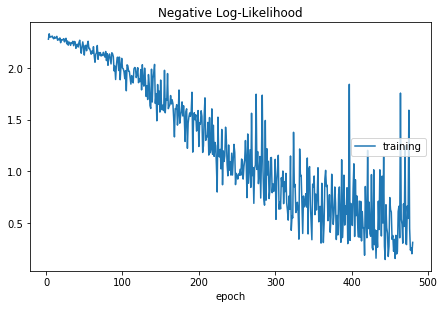

Negative Log-Likelihood:
training   (min:    0.145, max:    2.331, cur:    0.311)


In [11]:
#reload data in format fit for pytorch 
train = datasets.MNIST("", train=True, download =True, transform = transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST("", train =False, download =True, transform = transforms.Compose([transforms.ToTensor()]))
train_set = torch.utils.data.DataLoader(train, batch_size = 10, shuffle= True)
test_set = torch.utils.data.DataLoader(test, batch_size = 10, shuffle= True)

class Neural_Net(nn.Module):
    def __init__(self):
        super().__init__()
        #define layers of neural network:
        self.layer1 = nn.Linear(28*28, 64) #input dimensions x 64
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, 64)
        self.layer4 = nn.Linear(64, 10) #output = 10, as we have 10 classes 
    
    
    def forward(self, x):
        # define the path of the data through the network 
        x = F.relu(self.layer1(x)) #three layers with rectified linear activation function 
        x = F.relu(self.layer2(x)) 
        x = F.relu(self.layer3(x)) 
        x = self.layer4(x)
        
       
        return F.log_softmax(x, dim=1) #output is softmax, yielding probabilities for each class 
    
network = Neural_Net()
epochs = 8
optimizer = optim.Adam(params=network.parameters(), lr=1e-6)

def train(dataset, net, epochs):
    ''' Trains the network for the given number of epochs with the given data set, 
    while plotting the Negative Log-Likelihood Loss every 100 steps'''
    liveloss = PlotLosses()
    for epoch in range(epochs):
        c = 0
        for data in dataset:
            x, y = data 
            output = net(x.view(-1, 28*28))
       
            loss = F.nll_loss(output, y)
            loss.backward()
            optimizer.step()
            c = c+1
            if c % 100 == 0: 
                liveloss.update({'Negative Log-Likelihood': loss})
                liveloss.draw()

train(train_set, network, epochs)

In [12]:
correct = 0 
total = 0
labels = []
outputs = []
with torch.no_grad(): #no gradients because we just want to test
    for data in test_set:
        X,y = data
        output = network(X.view(-1, 28*28))
        
        for idx, i in enumerate(output):
            outputs.append(torch.argmax(i)) #store output and label for confusion matrix
            labels.append(y[idx])
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
print("Accuracy on Training Set: ", round(correct/total, 3))



Accuracy on Training Set:  0.849


[[ 929    0    2    2    1   31    8    1    5    1]
 [   0 1097    3    7    0    0    3    0   25    0]
 [  16   10  880   34   17    1   26   11   35    2]
 [  10    2   45  857    0   41    3   16   30    6]
 [   1    0    3    0  774    0   19    0   20  165]
 [  18    4    5   70   13  640   23   12   91   16]
 [  21    6   14    0   19   24  862    2   10    0]
 [   4   16   31    4    7    0    0  885   20   61]
 [   7   14   20   48    9   52    9   12  780   23]
 [   9    2    3    9  125   13    2   32   27  787]]


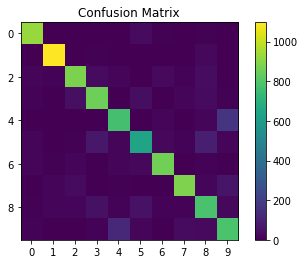

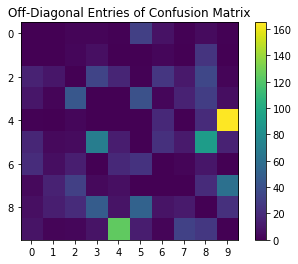

In [13]:
conf_mat = confusion_matrix(labels, outputs)
print(conf_mat)

#exclude diagonal entries to better illuminate where missclassifications happen 
off_conf_mat = np.copy(conf_mat)
for i in range(n_digits):
    for j in range(n_digits):
        if i == j:
            off_conf_mat[i,j]=0
          
plt.imshow(conf_mat)#.colorbar()
plt.colorbar()
plt.xticks(range(0,10))
plt.title('Confusion Matrix')
plt.show()

plt.imshow(off_conf_mat)#.colorbar()
plt.colorbar()
plt.xticks(range(0,10))
plt.title('Off-Diagonal Entries of Confusion Matrix')
plt.show()


## Classification Result

The Accuracy on the Test set was 84.9%, which is not perfect but reasonable for such a simple linear neural network. 
It is more interesting to look at the kind of errors which occur. For this purpose, I caluclated and plotted the confusion matrix. 
The confusion matrix shows how many instances of each class were predicted to be in which class. The rows show the true classes, the columns the predicted classes. Hence, the diagonal entries represent the correct predictions. Due to the moderate accuracy, they stand out. Therefor, I removed the correct predictions from the plot in order to make the pattern of missclasification visible. One can see that the digit 4 is often mistaken for a 9 by the linear network and vice versa. The digits 3, 5 and 8 also seem to get mixed up more often. On the other hand, the digits 0 and 1 seem to be mostly classified correctly.